In [1]:
import numpy as np
import pandas as pd
import random
import os 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

SEED = 42

def set_reproducibility(seed):
    # 1. Standard Python randomness
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 2. Modern NumPy (Generator-based)
    # Use this 'rng' for any direct numpy random calls in your code
    rng = np.random.default_rng(seed)
    # Optional: still set legacy global seed for libraries that depend on it
    np.random.seed(seed) 

    # 3. PyTorch (CPU and all GPUs)
    torch.manual_seed(seed) # for CPU/GPU weight initialization
    torch.cuda.manual_seed_all(seed) # ensures all GPUs are seeded if you use multiple. 

    # 4. Forcing Deterministic GPU Algorithms (Crucial for 2026)
    # This ensures operations like convolutions are identical every run
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # New: Force error if deterministic op isn't possible
    torch.use_deterministic_algorithms(True) 
    
    return rng

# Initialize your setup
rng = set_reproducibility(SEED)

In [2]:
class PreprocessingDataset(Dataset):
    def __init__(self, df, target_col=None, drop_cols=None, stats=None):
        """
        df: Input DataFrame
        target_col: Name of the label column
        drop_cols: List of non-predictive columns to remove (e.g., ['PassengerId', 'Name'])
        stats: Dictionary containing training means, stds, and mappings
        """
        # 1. DROP UNWANTED COLUMNS
        df = df.copy()
        if drop_cols:
            df = df.drop(columns=[c for c in drop_cols if c in df.columns])
        
        # 2. SEPARATE TARGET & IDENTIFY TYPES
        if target_col and target_col in df.columns:
            self.target = torch.tensor(df[target_col].values, dtype=torch.float32)
            data_df = df.drop(columns=[target_col])
        else:
            self.target = None
            data_df = df
        
        # Automatic Column Type Identification
        num_cols = data_df.select_dtypes(include=['int64', 'float64']).columns
        cat_cols = data_df.select_dtypes(include=['object', 'category']).columns
        
        num_tensor = torch.tensor(data_df[num_cols].values, dtype=torch.float32)
        cat_data = data_df[cat_cols].astype(str).values.tolist()

        # 3. LEAKAGE-FREE SCALING & MAPPING
        if stats is None:
            # Training Mode: Calculate Stats
            self.means = torch.nanmean(num_tensor, dim=0)
            temp_num = torch.where(torch.isnan(num_tensor), self.means, num_tensor)
            self.stds = torch.std(temp_num, dim=0)
            self.stds[self.stds == 0] = 1.0 
            
            self.cat_mappings = self._build_mappings(cat_data)
            self.stats = {'means': self.means, 'stds': self.stds, 'mappings': self.cat_mappings}
        else:
            # Validation Mode: Reuse Train Stats
            self.means = stats['means']
            self.stds = stats['stds']
            self.cat_mappings = stats['mappings']
            self.stats = stats

        # 4. APPLY TRANSFORMATIONS
        # Impute and Standardize
        num_imputed = torch.where(torch.isnan(num_tensor), self.means, num_tensor)
        self.num_final = (num_imputed - self.means) / self.stds
        
        # Encode Categories
        self.cat_final = self._encode(cat_data)

        # 5. CONSOLIDATE INTO ONE TENSOR
        self.X = torch.cat([self.num_final, self.cat_final], dim=1)

    def _build_mappings(self, data):
        if not data: return []
        mappings = []
        num_cols = len(data[0])
        for col_idx in range(num_cols):
            unique_vals = sorted(list(set(row[col_idx] for row in data)))
            # BEST PRACTICE: Map known categories starting at index 0, 
            # and use len(unique_vals) as the 'Unknown' bucket.
            mapping = {val: i for i, val in enumerate(unique_vals)}
            mapping['__unknown__'] = len(unique_vals)
            mappings.append(mapping)
        return mappings

    def _encode(self, data):
        if not data: return torch.empty((len(self.num_final), 0))
        encoded = []
        for row in data:
            # Safer: Use the dedicated '__unknown__' index for unseen data
            encoded_row = [
                self.cat_mappings[i].get(val, self.cat_mappings[i]['__unknown__']) 
                for i, val in enumerate(row)
            ]
            encoded.append(encoded_row)
        return torch.tensor(encoded, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.target is not None:
            return self.X[idx], self.target[idx]
        return self.X[idx]


Transferring statistics (such as mean, standard deviation, min, and max) from the training set to the validation set is done to prevent data leakage and to ensure the model is evaluated on data that has been processed in the exact same way it was trained. 

In [3]:
# Load data 
df = pd.read_csv("/kaggle/input/titanic/train.csv")
#test_df  = pd.read_csv("/kaggle/input/titanic/test.csv")

# --- 1. DATA CLEANING (Before Preprocessing) ---
# Drop columns that are unique IDs or too complex for a baseline
ID_COLS = ['PassengerId', 'Name', 'Ticket', 'Cabin']

# Validation split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Survived'], random_state=SEED)
# Stratification: ensures both sets have the same class distribution—this is essential for stable validation.

# 2. Create Train Dataset (Calculates internal stats and drops IDs)
train_ds = PreprocessingDataset(train_df, target_col='Survived', drop_cols=ID_COLS)

# 3. Create Val Dataset (Reuses stats from train_ds and drops IDs)
val_ds = PreprocessingDataset(val_df, target_col='Survived', drop_cols=ID_COLS, stats=train_ds.stats)

# 4. DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

stratify=df['Survived'] forces the train_test_split to maintain the same proportions of classes in both the training and validation sets as found in the original data.

Wrap in TensorDatasets
A TensorDataset pairs your features and labels into a single object that PyTorch can iterate through.

Create the DataLoaders
The DataLoader handles batching and shuffling. Shuffling is critical for the training set to prevent the model from learning the order of data. 
Training DataLoader: Set shuffle=True.
Validation DataLoader: Set shuffle=False (order doesn't affect evaluation).

Loss is a single numerical value that measures "how wrong" your model’s prediction was compared to the actual correct answer (the ground truth).

In [4]:
# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
    
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
# This code snippet dynamically assigns a hardware accelerator to your PyTorch model to ensure optimal performance during training or inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 50 # Example duration
# Reduces learning rate by half if validation loss doesn't improve for 5 epochs
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    #scheduler.step(epoch_val_loss)


Epoch 1/50 - Train Loss: 0.7209 | Val Loss: 0.7173
Epoch 2/50 - Train Loss: 0.7145 | Val Loss: 0.7117
Epoch 3/50 - Train Loss: 0.7087 | Val Loss: 0.7054
Epoch 4/50 - Train Loss: 0.7016 | Val Loss: 0.6978
Epoch 5/50 - Train Loss: 0.6928 | Val Loss: 0.6881
Epoch 6/50 - Train Loss: 0.6818 | Val Loss: 0.6760
Epoch 7/50 - Train Loss: 0.6683 | Val Loss: 0.6612
Epoch 8/50 - Train Loss: 0.6515 | Val Loss: 0.6447
Epoch 9/50 - Train Loss: 0.6326 | Val Loss: 0.6253
Epoch 10/50 - Train Loss: 0.6109 | Val Loss: 0.6058
Epoch 11/50 - Train Loss: 0.5896 | Val Loss: 0.5858
Epoch 12/50 - Train Loss: 0.5686 | Val Loss: 0.5693
Epoch 13/50 - Train Loss: 0.5512 | Val Loss: 0.5545
Epoch 14/50 - Train Loss: 0.5351 | Val Loss: 0.5412
Epoch 15/50 - Train Loss: 0.5204 | Val Loss: 0.5302
Epoch 16/50 - Train Loss: 0.5069 | Val Loss: 0.5173
Epoch 17/50 - Train Loss: 0.4941 | Val Loss: 0.5064
Epoch 18/50 - Train Loss: 0.4830 | Val Loss: 0.4973
Epoch 19/50 - Train Loss: 0.4750 | Val Loss: 0.4891
Epoch 20/50 - Train L

Most modern loss functions (like BCEWithLogitsLoss) prefer to take Logits directly because it is more numerically stable than calculating the Sigmoid first. This is why we often call the variable logits in our code

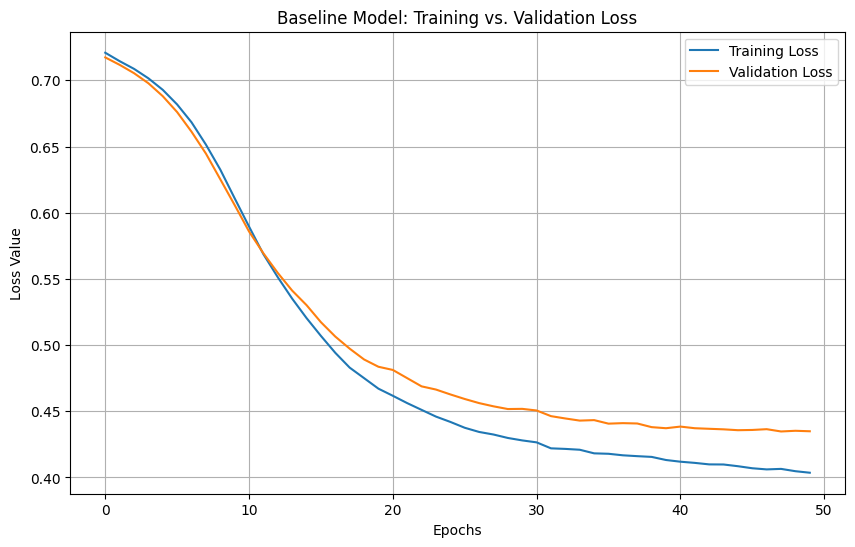

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()


Phase 1: No Regularization 

The Model is "Healthy": The fact that validation loss is not increasing significantly means the model hasn't completely "exploded" or overfit catastrophically.

Diminishing Returns: The improvement between Epoch 40 and 50 is negligible. Training for 50 epochs without regularization is slightly too long for this specific model size.

## Overfitting Regularization techniques

# 1. Dropout
Dropout remains one of the most effective and widely used regularization techniques to prevent neural networks from overfitting.

What is Dropout?
Dropout is a technique where, during each training step, a random percentage of neurons in a specific layer are "turned off" or "dropped".
The Probability: In your code, nn.Dropout(0.3) means that in every training pass, there is a 30% chance each neuron in that layer will be ignored.
Temporary: The neurons are not deleted; they are simply deactivated for that specific iteration. On the next pass, a different random 30% will be deactivated. It prevents overfitting by: 1. forcing independence 2. Preventing Co-adaptation 3. Acting like an ensemble


In [10]:
# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
        
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

it is considered a best practice to apply Batch Normalization alongside Dropout for tabular data. Batch Normalization stabilizes the "internal covariate shift," making training even faster.

In [11]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 50 # Example duration
# Reduces learning rate by half if validation loss doesn't improve for 5 epochs
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    #scheduler.step(epoch_val_loss)


Epoch 1/50 - Train Loss: 0.7080 | Val Loss: 0.6933
Epoch 2/50 - Train Loss: 0.6927 | Val Loss: 0.6796
Epoch 3/50 - Train Loss: 0.6779 | Val Loss: 0.6662
Epoch 4/50 - Train Loss: 0.6635 | Val Loss: 0.6502
Epoch 5/50 - Train Loss: 0.6472 | Val Loss: 0.6349
Epoch 6/50 - Train Loss: 0.6326 | Val Loss: 0.6185
Epoch 7/50 - Train Loss: 0.6165 | Val Loss: 0.6019
Epoch 8/50 - Train Loss: 0.5989 | Val Loss: 0.5836
Epoch 9/50 - Train Loss: 0.5858 | Val Loss: 0.5646
Epoch 10/50 - Train Loss: 0.5634 | Val Loss: 0.5476
Epoch 11/50 - Train Loss: 0.5470 | Val Loss: 0.5320
Epoch 12/50 - Train Loss: 0.5359 | Val Loss: 0.5176
Epoch 13/50 - Train Loss: 0.5163 | Val Loss: 0.5040
Epoch 14/50 - Train Loss: 0.5063 | Val Loss: 0.4917
Epoch 15/50 - Train Loss: 0.4950 | Val Loss: 0.4828
Epoch 16/50 - Train Loss: 0.4758 | Val Loss: 0.4747
Epoch 17/50 - Train Loss: 0.4853 | Val Loss: 0.4650
Epoch 18/50 - Train Loss: 0.4657 | Val Loss: 0.4604
Epoch 19/50 - Train Loss: 0.4556 | Val Loss: 0.4571
Epoch 20/50 - Train L

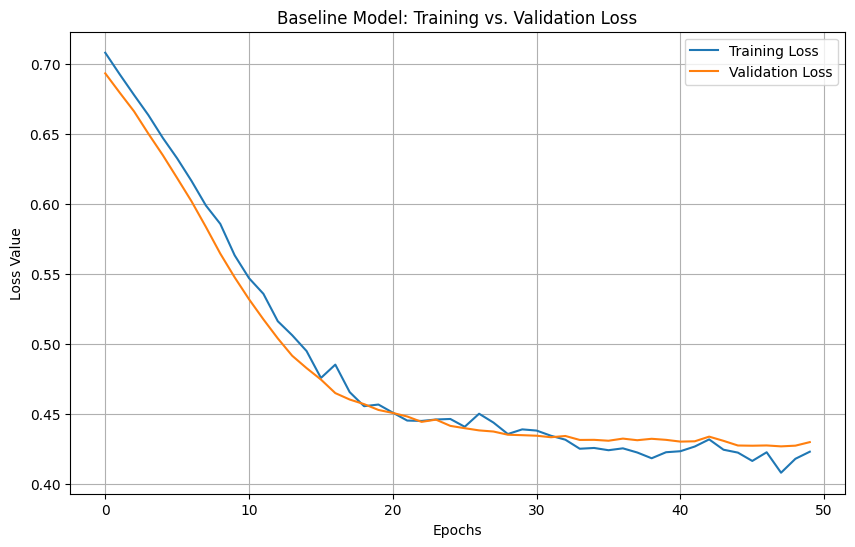

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

Analysis of the 0.1 Dropout Results
Best Generalization: The gap between training and validation loss (0.0069) is incredibly tight. This indicates the model is learning features that are almost perfectly applicable to unseen data.
Optimal Minimum: Your validation loss of 0.4274 (at Epoch 46) is the absolute lowest achieved across all experiments. This is the version of the model you should use for Kaggle.
Training Dynamics: The model is more stable than the 0.3 run but more robust than the 0.0 run. The slight "vibration" in Val Loss (moving from 0.4274 to 0.4300 in the final epochs) suggests that by Epoch 50, the model is starting to fluctuate around the global minimum.


# 2. Weight decay
Weight Decay remains a fundamental technique used to simplify models and prevent them from "memorizing" noise in your training data. 

What is Weight Decay?
Weight decay is a regularization technique that pushes your model's weights toward zero during training. 
The Mechanism: Every time the optimizer updates a weight, it also subtracts a small fraction of that weight's current value.
The Result: Only the most "useful" weights (those that significantly reduce the loss) are allowed to stay large. Unnecessary or weak weights eventually "decay" to near zero.

Why is it called L2 Regularization? 
In most standard optimizers (like SGD), weight decay is mathematically identical to adding a penalty term to your loss function called the L2 Norm. L2 Norm: This is the sum of the squares of all the weights in your model.The Logic: If your weights grow very large, the L2 penalty becomes huge, increasing your total loss. To minimize this total loss, the optimizer is forced to keep the weights small.Terminology: Because the derivative of (w^{2}) (L2) is (2w), the update step naturally subtracts a portion of the weight itself, leading to the name "Weight Decay".

In [16]:
# Model definition
class BaselineNet(nn.Module): # The physical structure of the brain (the neurons).
    def __init__(self, input_size):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.BatchNorm1d(16), # Added: Stabilizes inputs to the next layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            #nn.Sigmoid() BCEWithLogitsLoss handles it.
        )
        
    def forward(self, x): # The thought process (data goes in, a decision comes out).
        return self.net(x.float()) # Force float32 for safety

# setup
# Fetch the first item to see its shape
# train_ds[0] returns a tuple: (features, label)
first_features, _ = train_ds[0]
#Get the number of features (the size of the input tensor)
input_size = first_features.shape[0] 
model = BaselineNet(input_size=input_size)

# criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 prediction (how wrong was the decision?)
criterion = nn.BCEWithLogitsLoss() 
# Use AdamW for better out-of-the-box performance in 2026
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,           # Learning Rate: How fast to learn
    weight_decay=1e-2  # L2 Penalty: How much to punish complex models
)

Many experts prefer AdamW because it "decouples" the decay, ensuring it works exactly like the true L2 math you'd expect.

In [17]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 50 # Example duration
# Reduces learning rate by half if validation loss doesn't improve for 5 epochs
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    #scheduler.step(epoch_val_loss)


Epoch 1/50 - Train Loss: 0.7262 | Val Loss: 0.7198
Epoch 2/50 - Train Loss: 0.7154 | Val Loss: 0.7028
Epoch 3/50 - Train Loss: 0.7034 | Val Loss: 0.6912
Epoch 4/50 - Train Loss: 0.6920 | Val Loss: 0.6789
Epoch 5/50 - Train Loss: 0.6782 | Val Loss: 0.6632
Epoch 6/50 - Train Loss: 0.6614 | Val Loss: 0.6469
Epoch 7/50 - Train Loss: 0.6472 | Val Loss: 0.6320
Epoch 8/50 - Train Loss: 0.6275 | Val Loss: 0.6157
Epoch 9/50 - Train Loss: 0.6114 | Val Loss: 0.5943
Epoch 10/50 - Train Loss: 0.5877 | Val Loss: 0.5737
Epoch 11/50 - Train Loss: 0.5625 | Val Loss: 0.5551
Epoch 12/50 - Train Loss: 0.5443 | Val Loss: 0.5359
Epoch 13/50 - Train Loss: 0.5256 | Val Loss: 0.5209
Epoch 14/50 - Train Loss: 0.5069 | Val Loss: 0.5081
Epoch 15/50 - Train Loss: 0.4962 | Val Loss: 0.4887
Epoch 16/50 - Train Loss: 0.4737 | Val Loss: 0.4822
Epoch 17/50 - Train Loss: 0.4692 | Val Loss: 0.4740
Epoch 18/50 - Train Loss: 0.4568 | Val Loss: 0.4626
Epoch 19/50 - Train Loss: 0.4607 | Val Loss: 0.4581
Epoch 20/50 - Train L

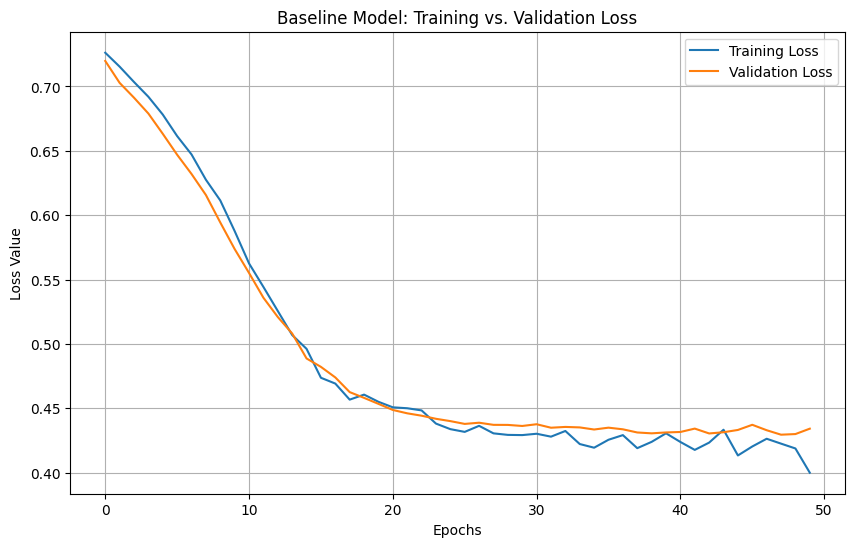

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

Over-regularized. Optimal Stopping: In both your best runs, the model consistently peaks around Epoch 48. Best model is the 0.1 Dropout (without Weight Decay) version

# 3. Early stopping
Stops when validation loss stops improving. This is how real models are trained. To add Early Stopping to your PyTorch model, you must implement a logic check at the end of each validation loop. Since PyTorch doesn't have a built-in EarlyStopping class like Keras, the standard practice is to create a small helper class or use a manual counter to track if your validation loss has stopped improving. Early stopping relies on two main variables: 
Patience: How many epochs you are willing to wait for an improvement before giving up.
Best Score: The lowest validation loss achieved so far. 

In [21]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='best_model.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        # Higher score is better, so we use negative loss
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
    def save_checkpoint(self, model):
        '''Saves model when validation loss decreases.'''
        torch.save(model.state_dict(), self.path)

In [22]:
# Setup device (e.g., 'cuda', 'mps' for Mac, or 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# The training and validation loop
train_losses = []
val_losses = []
epochs = 100 # Example duration
# Reduces learning rate by half if validation loss doesn't improve for 5 epochs
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
# Initialize Early Stopping
early_stopper = EarlyStopping(patience=10, path='best_model.pt')

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # .view(-1) is safer than .squeeze() for binary classification
        loss = criterion(outputs.view(-1), labels.float()) # Changes (64, 1) to (64)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Log training loss

    # --- PHASE 2: VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            running_val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss) # Log validation loss

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    #scheduler.step(epoch_val_loss)

    # --- PHASE 3: EARLY STOPPING CHECK (Outside the DataLoader loop) ---
    # Pass the epoch_val_loss and the model to save the best weights
    early_stopper(epoch_val_loss, model) 
    
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights...")
        # map_location ensures it loads correctly on any device
        model.load_state_dict(torch.load('best_model.pt', weights_only=True, map_location=device))
        break

Epoch 1/100 - Train Loss: 0.4091 | Val Loss: 0.4293
Epoch 2/100 - Train Loss: 0.4030 | Val Loss: 0.4290
Epoch 3/100 - Train Loss: 0.4100 | Val Loss: 0.4280
Epoch 4/100 - Train Loss: 0.4090 | Val Loss: 0.4299
Epoch 5/100 - Train Loss: 0.4127 | Val Loss: 0.4271
Epoch 6/100 - Train Loss: 0.4093 | Val Loss: 0.4280
Epoch 7/100 - Train Loss: 0.4222 | Val Loss: 0.4324
Epoch 8/100 - Train Loss: 0.4067 | Val Loss: 0.4262
Epoch 9/100 - Train Loss: 0.4048 | Val Loss: 0.4267
Epoch 10/100 - Train Loss: 0.4047 | Val Loss: 0.4267
Epoch 11/100 - Train Loss: 0.4210 | Val Loss: 0.4260
Epoch 12/100 - Train Loss: 0.4128 | Val Loss: 0.4273
Epoch 13/100 - Train Loss: 0.4018 | Val Loss: 0.4315
Epoch 14/100 - Train Loss: 0.4033 | Val Loss: 0.4316
Epoch 15/100 - Train Loss: 0.4079 | Val Loss: 0.4335
Epoch 16/100 - Train Loss: 0.4213 | Val Loss: 0.4319
Epoch 17/100 - Train Loss: 0.4045 | Val Loss: 0.4278
Epoch 18/100 - Train Loss: 0.4121 | Val Loss: 0.4272
Epoch 19/100 - Train Loss: 0.4066 | Val Loss: 0.4338
Ep

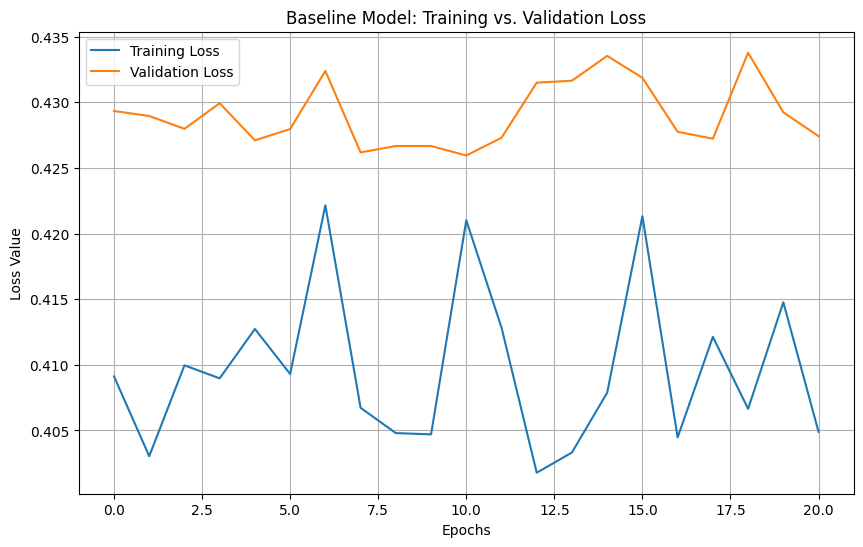

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Use labels so the legend knows which line is which
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Standard formatting for 2026 reports
plt.title('Baseline Model: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend() # Automatically uses the labels defined above
plt.grid(True) # Makes it easier to pinpoint specific epochs
plt.show()

Best Score: Achieved a Validation Loss of 0.4260 at Epoch 11. This is the best (lowest) loss recorded across all your experiments today.  The model is now in its optimized state. The weights currently loaded in model are the best-performing ones recorded during the run.

## Reflections

1. Validation beats leaderboard.
2. Regularization is not optional.
3. Early stopping is deep learning's seat belt